In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import linalg as LA

#from load_data_mongoloids import load_data_mongoloids
#from mongoloids_config import config

#from load_data_cancer import load_data_cancer
#from cancer_config import config
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#import plotly.plotly as py
import textwrap
import scipy.stats as stats

from sklearn import svm, datasets
from scipy import stats
from sklearn import neighbors, ensemble, linear_model, neural_network
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy
from functools import partial

from infrastructure.configuration import param
import matplotlib.pylab as pylab
import seaborn
seaborn.set_style('darkgrid', {'legend.frameon':True})
fontsize = 20
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'font.size':fontsize}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

plt.style.use('ggplot')
%matplotlib inline

import igraph
import cairo
from tqdm import tqdm
import pandas as pd

In [2]:
#from configurations.load_data_down_GSE52588 import load_data_down_GSE52588
#from configurations.config_down_GSE52588 import config

from configurations.load_data_down_GSE52588 import load_data_down_GSE52588_cpgs
from configurations.config_down_GSE52588_cpg import config

In [3]:
X, y, mask, features_names = load_data_down_GSE52588_cpgs()

Data loaded:  66.344918816
float32 (422801, 87)
(87, 422801)
(87, 422801) 150253 (87,) (422801,)


In [4]:
from annotations.cpgs import cpgs_annotation
cpgs = cpgs_annotation(config.ifname('cpgs_annotations'))

In [5]:
bad_cpgs = np.loadtxt(config.ifname('bad_cpgs'), dtype='str')

In [6]:
groups = ["mongoloids_mask", "siblings_mask", "mothers_mask"]
group_masks = [0] * 3
for j, group_name in enumerate(groups):
    group_masks[j] = config.params[group_name].value
        

In [108]:

def calc_epimutations(X, group_masks):
    epimutations_sum = np.zeros((X.shape[0], ), dtype = np.int32)
    epimutations = np.zeros((X.shape[0], X.shape[1]), dtype = np.bool)
    for i in tqdm(range(X.shape[1]), ncols = 100):
        for j, mask in enumerate(group_masks):
            x = X[mask, i]
            q = np.quantile(x, [0.25, 0.75])
            iqr = q[1] - q[0]
            q[0] -= iqr * 3
            q[1] += iqr * 3
            epimutations[mask, i] = ((x > q[1]) | (x < q[0]))
            epimutations_sum[mask] += ((x > q[1]) | (x < q[0])).astype('int32')
    return epimutations_sum, epimutations

epimutations_sum, epimutations = calc_epimutations(X, group_masks)
epimutations_sum_r, epimutations_r = calc_epimutations(X_r, group_masks)
epimutations_sum_r2, epimutations_r2 = calc_epimutations(X_r2, group_masks)

100%|█████████████████████████████████████████████████████| 422801/422801 [03:03<00:00, 2309.52it/s]


# Trverse chromosome

In [92]:
def traverse_chromosomes(features_names, bad_cpgs, path_kernel_geotype, kernel):
    df = cpgs.get_sub_frame({'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs})
    chromosomes = df.CHR.unique()

    ids = np.argsort(list(map(lambda x: "0" + x if len(x) == 1 and x[0].isdigit() else x, chromosomes)))
    chromosomes = chromosomes[ids]
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel_geotype) as pdf:
        for chromosome in tqdm(chromosomes, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'chr_in': chromosome, 'cpgs_out': bad_cpgs}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Chromosome: " + chromosome)
            
            pdf.savefig()
            plt.close()
            #break

# Traverse geo type

In [88]:
def traverse_geo_types(features_names, bad_cpgs, path_kernel_geotype, kernel):
    geotypes = cpgs.get_crit_col_values('geotype', \
            {'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'geotype_out': [np.NaN], 'chr_out': ['X', 'Y']})
    geotypes.sort()
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(path_kernel_geotype) as pdf:
        for geotype in tqdm(geotypes, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'geotype_in': [geotype], 'cpgs_out': bad_cpgs}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Geotype: " + geotype)
            
            pdf.savefig()
            plt.close()
            #break

# Traverse gene part

In [89]:
def traverse_gene_parts(features_names, bad_cpgs, path_kernel_genepart, kernel):
    geneparts = cpgs.get_crit_col_values('genepart', \
                {'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'genepart_out': [np.NaN], 'chr_out': ['X', 'Y']})
    geneparts.sort()
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel_genepart) as pdf:
        for genepart in tqdm(geneparts, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'genepart_in': [genepart], 'cpgs_out': bad_cpgs}) # 'genepart_in': ['Island', 'N_Shore', 'S_Shore']
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Genepart: " + genepart)
            
            pdf.savefig()
            plt.close()
            #break

# Traverse cpg list

In [90]:
def calc_for_cpg_list(cpgs_in, bad_cpgs, path_kernel, kernel, title = ''):
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel) as pdf:
        cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': cpgs_in, 'cpgs_out': bad_cpgs}) 
        cpgs_names, ids, ids2 = np.intersect1d(cpgs_in, cpgs_names, return_indices = True)

        kernel(ids, title)

        pdf.savefig()
        plt.close()
        #break

In [7]:
'''
def kernel_epimutations(ids, title, groups = groups, y = y, epimutations = epimutations):
    sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
    plot_epimutations(sub_epimutations_sum, groups, y, '', title = title)

def kernel_epimutations_boxplot(ids, title, groups = groups, y = y, epimutations = epimutations):
    sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
    plot_epimutations_boxplot(sub_epimutations_sum, groups, y, '', title = title)
'''    
def kernel_variance(ids, title, X = X, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)

def kernel_variance_boxplot(ids, title, X = X, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance_boxplot(sd, groups, group_masks, y, title)

'''
def kernel_variance_r(ids, title, X = X_r, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)
    
def kernel_variance_r2(ids, title, X = X_r2, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)        
'''

'\ndef kernel_variance_r(ids, title, X = X_r, group_masks = group_masks, groups = groups):\n    sd = variance_analyze(X, ids, group_masks)\n    plot_variance(sd, groups, group_masks, y, title)\n    \ndef kernel_variance_r2(ids, title, X = X_r2, group_masks = group_masks, groups = groups):\n    sd = variance_analyze(X, ids, group_masks)\n    plot_variance(sd, groups, group_masks, y, title)        \n'

In [63]:
def get_cpgs(input_type = 1, fname = '', col_name = 'nameCpG'):
    global cached_cpgs
    try:
        cached_cpgs
    except:
        cached_cpgs = dict()
    try:
        cached_cpgs[fname]
    except:
        df = pd.read_csv(fname, sep = '\t')
        cached_cpgs[fname] = df[col_name].values
    return cached_cpgs[fname]
    
def get_down_related_2015_cpgs(input_type = 1):
    global down_related_2015_cpgs
    try:
        down_related_2015_cpgs
    except:
        df = pd.read_csv(config.ifname('down_related_2015_cpgs'))
        down_related_2015_cpgs = df['ID_REF_Best_CpG'].values
    return down_related_2015_cpgs

def var_diff_p(x, y):
    F = x.var() / y.var()
    p_value = scipy.stats.f.cdf(F, len(x) - 1, len(y) - 1)
    return p_value # True : Reject the null hypothesis that Var(X) == Var(Y)
        

def make_std_related(X, features_names = features_names, group_masks = group_masks):
    diff_p = [np.zeros((X.shape[1], ), dtype = np.bool) for i in range(3)]
    for i in tqdm(range(X.shape[1]), ncols = 100):
        cur = X[:, i]
        diff_p[0][i] = var_diff_p(cur[group_masks[0]], cur[group_masks[1]])
        diff_p[1][i] = var_diff_p(cur[group_masks[1]], cur[group_masks[2]])
        diff_p[2][i] = var_diff_p(cur[group_masks[0]], cur[group_masks[2]])
    return diff_p
    

#diff_p = make_std_related(X, group_masks = group_masks)
#diff_p_r = make_std_related(X_r, group_masks = group_masks)
#diff_p_r2 = make_std_related(X_r2, group_masks = group_masks)

def get_std_related(input_type = 1, features_names = features_names, num_cpgs = 1000):
    global diff_p, diff_p_r, diff_p_r2
    if input_type == 1:
        cur = diff_p
    if input_type == 2:
        cur = diff_p_r
    if input_type == 3:
        cur = diff_p_r2
    ids = np.unique([np.argsort(cur[0])[-num_cpgs:], np.argsort(cur[1])[-num_cpgs:], np.argsort(cur[2])[-num_cpgs:]])
    return features_names[ids]

In [38]:
np.savez_compressed(config.ifname("var_diff_pv"), diff_p = diff_p, diff_p_r = diff_p_r, diff_p_r2 = diff_p_r2)

In [75]:
np.all(X == X_r)

False

In [61]:
path_cpgs_age_M = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_M"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_F = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_F"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_Igor = config.ofname([["age_related"], ["cpgs_variance"]], ext = ".txt", include_set = config.params_sets["age_related"])

get_cpgs(fname = path_cpgs_age_Igor, col_name = 'nameCpG')

.
.
.


array(['cg17839237', 'cg21502255', 'cg22058122', 'cg13566610',
       'cg11113760', 'cg25032595', 'cg03823904', 'cg16976910',
       'cg26477573', 'cg10652091', 'cg10483871', 'cg25829666',
       'cg22871668', 'cg16999584', 'cg12040830', 'cg17025835',
       'cg16150752', 'cg01116059', 'cg24403845', 'cg02467990',
       'cg02169338', 'cg18081940', 'cg07420190', 'cg03117976',
       'cg23217622', 'cg00323305', 'cg04226749', 'cg00370229',
       'cg11664500', 'cg21186299', 'cg02457680', 'cg14287112',
       'cg20448717', 'cg01939883', 'cg26170604', 'cg16560774',
       'cg20984053', 'cg25105066', 'cg25379026', 'cg12950911',
       'cg09493505', 'cg17942573', 'cg16918905', 'cg11639849',
       'cg13906571', 'cg16427096', 'cg24436446', 'cg14032732',
       'cg16366843', 'cg02664812', 'cg15202738', 'cg24565369',
       'cg17652756', 'cg03867465', 'cg14533206', 'cg15490715',
       'cg24996482', 'cg01499217', 'cg26802289', 'cg15708153',
       'cg10795666', 'cg26464821', 'cg24721899', 'cg105

In [53]:
sd = variance_analyze(X, range(X.shape[1]), group_masks)

In [54]:
var = [0, 0, 0]
var[0] = sd[0] ** 2
var[1] = sd[1] ** 2
var[2] = sd[2] ** 2

In [57]:
var[0], var[1], var[2]
sd[0], sd[1], sd[2]

(array([0.05766241, 0.00658216, 0.02577584, ..., 0.03810199, 0.03238373,
        0.00308951], dtype=float32),
 array([0.05097779, 0.00699519, 0.01343124, ..., 0.02412374, 0.02362443,
        0.00340381], dtype=float32),
 array([0.06722929, 0.00585764, 0.00906403, ..., 0.01885523, 0.01574338,
        0.00195613], dtype=float32))

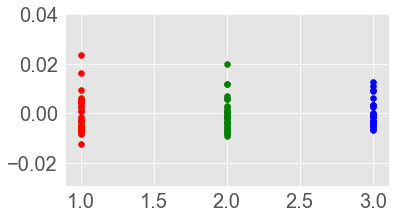

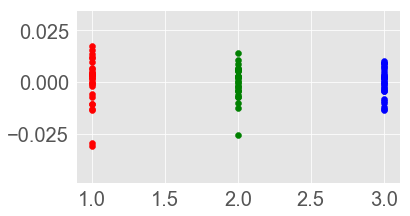

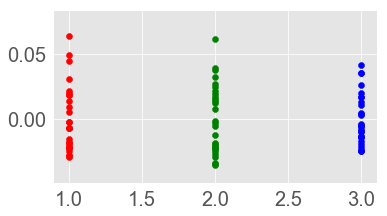

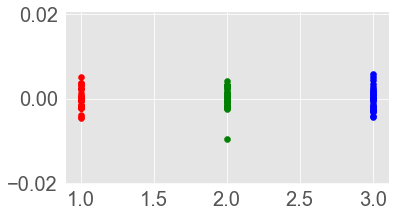

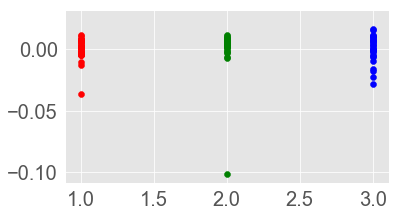

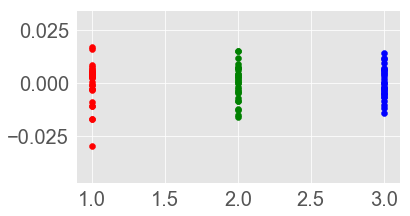

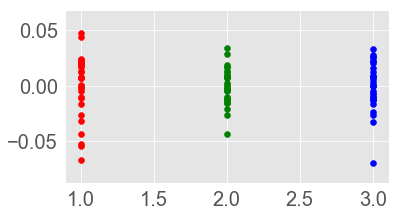

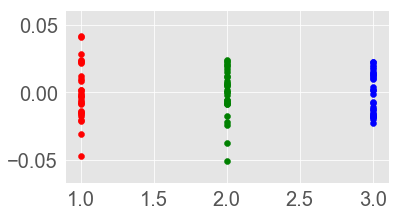

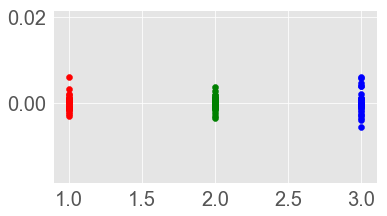

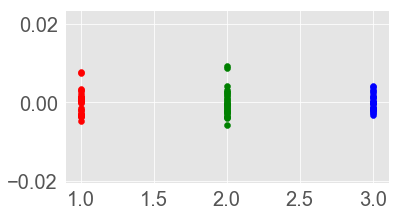

In [28]:
for cid in ids[-10:]:
    plt.figure()
    plt.scatter(np.ones(29), X[group_masks[0], cid] - X[group_masks[0], cid].mean(), c = 'r')
    plt.scatter(np.ones(29) * 2, X[group_masks[1], cid] - X[group_masks[1], cid].mean(), c = 'g')
    plt.scatter(np.ones(29) * 3, X[group_masks[2], cid] - X[group_masks[2], cid].mean(), c = 'b')
    #plt.legend(["Down", "Siblings", "Mothers"], framealpha=0.9, fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #           ncol=3, mode="expand", borderaxespad=0., handletextpad=0.3, scatterpoints=1)    
    plt.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.95)
    #plt.title(str(is_diff[0][cid]) + ' ' + str(is_diff[1][cid]) + ' ' + str(is_diff[2][cid]))

In [49]:
for i in tqdm(range(10)):
    pass


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 5003.34it/s]

In [86]:
path_cpgs_age_M = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_M"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_F = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_F"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_Igor = config.ofname([["age_related"], ["cpgs_variance"]], ext = ".txt", include_set = config.params_sets["age_related"])

cpgs_in_subset = {'age_related_Olga_M': partial(get_cpgs, fname = path_cpgs_age_M),
                  'age_related_Olga_F': partial(get_cpgs, fname = path_cpgs_age_F),
                  'age_related_Igor': partial(get_cpgs, fname = path_cpgs_age_Igor),
                  'down_related_2015': get_down_related_2015_cpgs,
                  'std_related': get_std_related}
    
for subset_name, get_subset in cpgs_in_subset.items():
    path_variance = config.ofname([["down_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    
    calc_for_cpg_list(get_subset(1), bad_cpgs, path_variance, kernel_variance)

    #
    path_variance = config.ofname([["regressout_cells_down_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    calc_for_cpg_list(get_subset(2), bad_cpgs, path_variance, partial(kernel_variance, X = X_r))
    
    #
    path_variance = config.ofname([["regressout_cells_age_down_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    calc_for_cpg_list(get_subset(3), bad_cpgs, path_variance, partial(kernel_variance, X = X_r2))
    
    # Boxplots
    path_variance = config.ofname([["down_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    
    calc_for_cpg_list(get_subset(1), bad_cpgs, path_variance, kernel_variance_boxplot)

    #
    path_variance = config.ofname([["regressout_cells_down_cpg_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    calc_for_cpg_list(get_subset(2), bad_cpgs, path_variance, partial(kernel_variance_boxplot, X = X_r))
    
    #
    path_variance = config.ofname([["regressout_cells_age_down_cpg_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    calc_for_cpg_list(get_subset(3), bad_cpgs, path_variance, partial(kernel_variance_boxplot, X = X_r2))
    

In [93]:

cpg_subsets = {'geneparts': traverse_gene_parts, 
               'geotypes': traverse_geo_types,
               'chromosomes': traverse_chromosomes}

for subset_name, traverse_subset in cpg_subsets.items():
    # Epimutation
    path_epimutations = config.ofname([["down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutations, kernel_epimutations)
    print(path_epimutations)
    
    path_epimutations = config.ofname([["regressout_cells_down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutations, partial(kernel_epimutations, epimutations = epimutations_r))
    
    path_epimutations = config.ofname([["regressout_cells_age_down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutations, partial(kernel_epimutations, epimutations = epimutations_r2))
    
    
    # Epimutation boxplots
    path_epimutation_boxplots = config.ofname([["down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, kernel_epimutations_boxplot)
    
    path_epimutation_boxplots = config.ofname([["regressout_cells_down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, partial(kernel_epimutations_boxplot, epimutations = epimutations_r))
    
    path_epimutation_boxplots = config.ofname([["regressout_cells_age_down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, partial(kernel_epimutations_boxplot, epimutations = epimutations_r2))
    
    # Variance
    path_variance = config.ofname([["down_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    traverse_subset(features_names, bad_cpgs, path_variance, kernel_variance)
    
    path_variance_boxplot = config.ofname([["down_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    traverse_subset(features_names, bad_cpgs, path_variance_boxplot, kernel_variance_boxplot)
    
    path_variance = config.ofname([["regressout_cells_down_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    traverse_subset(features_names, bad_cpgs, path_variance, partial(kernel_variance, X = X_r))
    
    path_variance = config.ofname([["regressout_cells_age_down_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
    traverse_subset(features_names, bad_cpgs, path_variance, partial(kernel_variance, X = X_r2))
    
# Epimutations
'''
path_epimutations_genepart = config.ofname([["down_epimutations"], ["epimutation", "geneparts"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
traverse_gene_parts(feature_names, bad_cpgs, path_epimutations_genepart, kernel_epimutations)

### Variance

# Genepart

path_variance_genepart = config.ofname([["down_variance"], ["variance", "geneparts"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
traverse_gene_parts(features_names, bad_cpgs, path_variance_genepart, kernel_variance)

# 
path_epimutations_geotype = config.ofname([["down_epimutations"], ["epimutation", "geotypes"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])

path_epimutations_chromosome = config.ofname([["down_epimutations"], ["epimutation", "chromosomes"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
'''


F:\PC\UNN\Scientific\Gerontology\data\GSE52588\params\num_cpgs_150253\kde_mask_healthy_mask\algorithm_svc\down_epimutations\epimutation_geneparts.pdf
['TSS1500', "3'UTR", 'Body', 'Body', "3'UTR", "3'UTR", '1stExon', 'TSS1500', 'TSS200', 'Body']


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.70s/it]


['TSS1500', "3'UTR", 'Body', 'Body', "3'UTR", "3'UTR", '1stExon', 'TSS1500', 'TSS200', 'Body']


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]


['TSS1500', "3'UTR", 'Body', 'Body', "3'UTR", "3'UTR", '1stExon', 'TSS1500', 'TSS200', 'Body']


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.34s/it]


['TSS1500', "3'UTR", 'Body', 'Body', "3'UTR", "3'UTR", '1stExon', 'TSS1500', 'TSS200', 'Body']


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.75s/it]


F:\PC\UNN\Scientific\Gerontology\data\GSE52588\params\num_cpgs_150253\kde_mask_healthy_mask\algorithm_svc\down_epimutations\epimutation_geotypes.pdf
['N_Shore', 'N_Shore', 'N_Shore', 'S_Shore', 'Island', 'Island', 'S_Shore', 'S_Shelf', 'Island', 'Island']


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


['N_Shore', 'N_Shore', 'N_Shore', 'S_Shore', 'Island', 'Island', 'S_Shore', 'S_Shelf', 'Island', 'Island']


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.20s/it]


['N_Shore', 'N_Shore', 'N_Shore', 'S_Shore', 'Island', 'Island', 'S_Shore', 'S_Shelf', 'Island', 'Island']


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.88s/it]


['N_Shore', 'N_Shore', 'N_Shore', 'S_Shore', 'Island', 'Island', 'S_Shore', 'S_Shelf', 'Island', 'Island']


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.94s/it]


F:\PC\UNN\Scientific\Gerontology\data\GSE52588\params\num_cpgs_150253\kde_mask_healthy_mask\algorithm_svc\down_epimutations\epimutation_chromosomes.pdf


100%|███████████████████████████████████████████████████████████████| 23/23 [01:25<00:00,  3.60s/it]


'\npath_epimutations_genepart = config.ofname([["down_epimutations"], ["epimutation", "geneparts"]], ext = ".pdf", \n                                                 include_set = config.params_sets["down_epimutations"])\ntraverse_gene_parts(feature_names, bad_cpgs, path_epimutations_genepart, kernel_epimutations)\n\n### Variance\n\n# Genepart\n\npath_variance_genepart = config.ofname([["down_variance"], ["variance", "geneparts"]], ext = ".pdf", \n                                                 include_set = config.params_sets["down_epimutations"])\ntraverse_gene_parts(features_names, bad_cpgs, path_variance_genepart, kernel_variance)\n\n# \npath_epimutations_geotype = config.ofname([["down_epimutations"], ["epimutation", "geotypes"]], ext = ".pdf", \n                                                 include_set = config.params_sets["down_epimutations"])\n\npath_epimutations_chromosome = config.ofname([["down_epimutations"], ["epimutation", "chromosomes"]], ext = ".pdf", \n            

318391
1970.2413793103449
1640.7241379310344
1913.655172413793


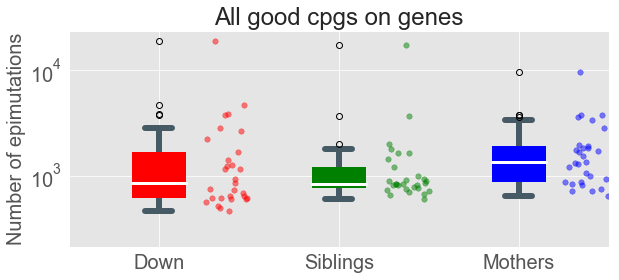

In [118]:
from scipy import stats
#plt.boxplot([epimutations[y == 0], epimutations[y == 1], epimutations[y == 2]])
def plot_epimutations(epimutations_sum, groups, y, path_epimutations, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    my = 0
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        kde = stats.gaussian_kde(x)
        xx = np.linspace(0, max(x) * 1.5, 300)
        yy = kde(xx)
        ax.plot(xx, yy, colors[j], alpha = 0.5, linewidth = 3)
        my = max(my, max(yy))
    
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        dy = my * 0.025
        yy = -np.random.rand(x.shape[0]) * dy * 0.8 - 2.5 * dy * j - dy
        ax.scatter(x, yy, c = colors[j], alpha = 0.5, s = 30)
        #plt.hist(x, color = colors[j], alpha = 0.5)
    #plt.xlim(left = 0)
    #ax.ticklabel_format(scilimits = [-7, 0])
    plt.legend(["Down", "Siblings", "Mothers"])
    plt.xlabel('Number of epimutations per subject\n($\\beta < Q_1 - 3 \\cdot {\\bf IQR}$ or $Q_3 + 3 \\cdot {\\bf IQR} < \\beta$)', fontsize = fontsize)
    plt.ylabel('${\\bf PDF}$', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.95)
    #plt.show()
    if path_epimutations != '':
        plt.savefig(path_epimutations)

def plot_epimutations_boxplot(epimutations_sum, groups, y, path_epimutations, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    xx = []
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        xx.append(x)
        print(np.mean(x))
    
    boxprops=dict(linewidth = 0)
    capprops= whiskerprops=dict(color='#455A64', linewidth = 6)
    
    bplot = ax.boxplot(xx, labels = ["Down", "Siblings", "Mothers"], patch_artist=True, boxprops=boxprops,whiskerprops =whiskerprops, capprops =capprops )
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set(color='w', linewidth=3)
    
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        yy = j + np.random.rand(x.shape[0]) * 0.25 + 1 + 0.25
        ax.scatter(yy, x, c =  colors[j], alpha = 0.5, s = 30)
        #plt.hist(x, color = colors[j], alpha = 0.5)
    
    ax.set_yscale('log')
    #plt.xlim(left = 0)
    #ax.ticklabel_format(scilimits = [-7, 0])
    #plt.legend(["Down", "Siblings", "Mothers"], framealpha=0.9, fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #       ncol=3, mode="expand", borderaxespad=0., handletextpad=0.3, scatterpoints=3)    
    #plt.xlabel('Number of epimutations per subject\n($\\beta < Q_1 - 3 \\cdot {\\bf IQR}$ or $Q_3 + 3 \\cdot {\\bf IQR} < \\beta$)', fontsize = fontsize)
    plt.ylabel('Number of epimutations', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.95)
    #plt.show()
    if path_epimutations != '':
        plt.savefig(path_epimutations)
        
cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
print(len(ids))
sub_epimutations_sum = epimutations_r[:, ids].astype('int32').sum(axis = 1)
plot_epimutations_boxplot(sub_epimutations_sum, groups, y, '', 'All good cpgs on genes')

91875


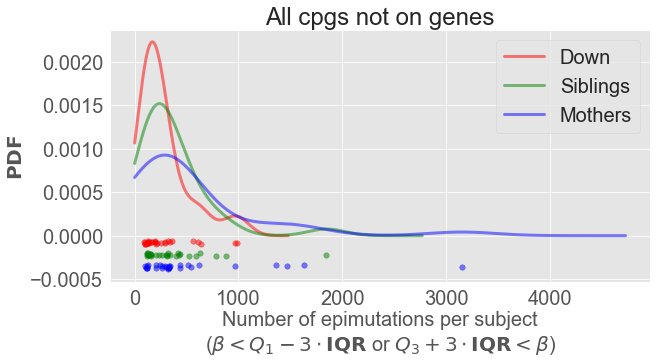

In [69]:
cpgs_names, ids = cpgs.get_cpgs({'gene_in': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
print(len(ids))
sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
plot_epimutations(sub_epimutations_sum, groups, y, '', 'All cpgs not on genes')

In [66]:
cpgs_names, ids = cpgs.get_cpgs({'gene_in': [np.NaN]}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']

In [68]:
len(ids)

119977

In [85]:
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')

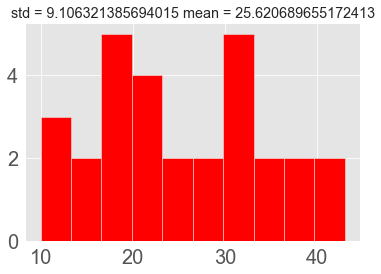

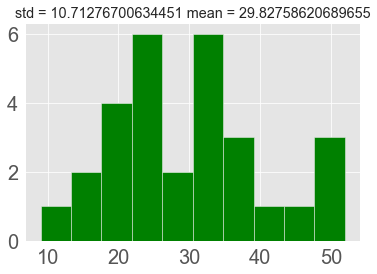

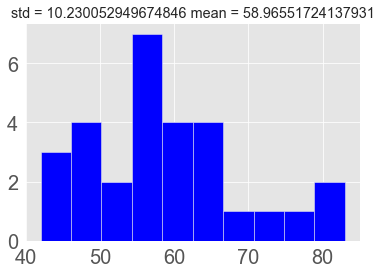

In [94]:
ages = patients_info["age"].values
colors = ['r', 'g', 'b']
for i, mask in enumerate(group_masks):
    plt.figure()
    plt.hist(ages[mask], color=colors[i])
    plt.title('std = ' + str(ages[mask].std()) + ' mean = ' + str(ages[mask].mean()))
#plt.figure()
#plt.hist(ages[29:29*2], color='g')
#plt.figure()
#plt.hist(ages[29*2:29*3], color='b')



# CpG variance

In [7]:
def variance_analyze(X, ids, group_masks):
    sd = [0] * len(group_masks)
    for j, mask in enumerate(group_masks):
        x = X[mask, :]
        sd[j] = np.std(x[:, ids], axis = 0)
    return sd

#sd = []

#pdf.savefig()
#plt.close()


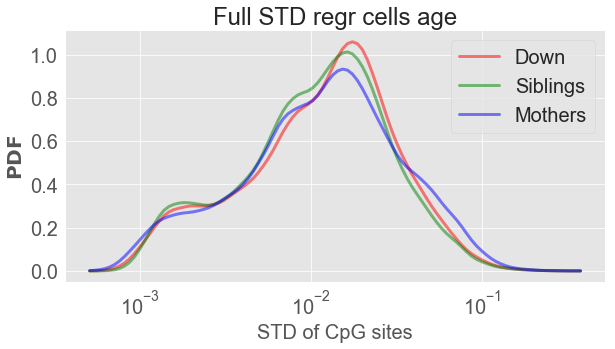

In [30]:
from scipy import stats
#plt.boxplot([epimutations[y == 0], epimutations[y == 1], epimutations[y == 2]])
def plot_variance(sd, groups, group_masks, y, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    my = 0
    mn = 100
    for j, mask in enumerate(group_masks):
        x = sd[j]
        my = max(my, max(x))
        mn = min(my, min(x))
    #mn = 1e-3
    for j, mask in enumerate(group_masks):
        x = sd[j]
        kde = stats.gaussian_kde(np.log10(x))
        xx = np.linspace(np.log10(mn), np.log10(my), 100)
        yy = kde(xx)
        ax.plot(10 ** xx, yy, colors[j], alpha = 0.5, linewidth = 3)
        ##n,x,_ = ax.hist(x, np.linspace(np.log10(mn), np.log10(my), 40), histtype=u'step', density=True, linewidth = 0)
        
        #n,x,_ = ax.hist(x, xx, histtype=u'step', density=True, linewidth = 0)
        #bin_centers = 0.5*(x[1:]+x[:-1])
        #ax.plot(bin_centers,n, linewidth = 3, c = colors[j])
        
    
    #ax.set_yscale('log')
    ax.set_xscale('log')
    #plt.xlim(left = 0, right = my)
    #plt.ylim(bottom = 1e-5)
    #ax.ticklabel_format(scilimits = [-7, 0])
    plt.legend(["Down", "Siblings", "Mothers"])
    plt.xlabel('STD of CpG sites', fontsize = fontsize)
    plt.ylabel('${\\bf PDF}$', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.95)
    #plt.show()
    
def plot_variance_boxplot(sd, groups, group_masks, y, title):
    colors = ['r', 'g', 'b']
    my = 0
    
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    xx = []
    for j, mask in enumerate(group_masks):
        x = sd[j]
        xx.append(x)
    
    boxprops=dict(linewidth = 0)
    capprops= whiskerprops=dict(color='#455A64', linewidth = 6)
    
    bplot = ax.boxplot(xx, labels = ["Down", "Siblings", "Mothers"], patch_artist=True, boxprops=boxprops,whiskerprops =whiskerprops, capprops =capprops )
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set(color='w', linewidth=3)
    
    for j, mask in enumerate(group_masks):
        x = sd[j]
        yy = j + np.random.rand(x.shape[0]) * 0.25 + 1 + 0.25
        #ax.scatter(yy, x, c =  colors[j], alpha = 0.5, s = 30)
    
    ax.set_yscale('log')
    
    plt.ylabel('STD of CpG sites', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.95)

#cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
#cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)

sd = variance_analyze(X, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
##plot_variance(sd, groups, group_masks, y, 'Full STD')

sd = variance_analyze(X_r, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
##plot_variance(sd, groups, group_masks, y, 'Full STD regr cells')

sd = variance_analyze(X_r2, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
plot_variance(sd, groups, group_masks, y, 'Full STD regr cells age')

In [27]:
len(ids)

318391

In [89]:
sd[2].max()

0.3515566

In [24]:
def regress_out_cells(X, is_age):
    df_cells = pd.read_csv(config.ifname('cells'), delimiter = '\t')
    from sklearn.linear_model import LinearRegression
    cells_cols = ['CD8T', 'CD4T', 'NK', 'Bcell', 'Gran']
    df_sub_cells = df_cells[cells_cols]
    if is_age:
        df_sub_cells["age"] = patients_info["age"].values
    #ages = patients_info["age"].values
    data = df_sub_cells.values
    X_r = np.array(X)
    for i in tqdm(range(len(features_names)), ncols = 100):
        beta = X[:, i]
        model = LinearRegression()
        model.fit(data, beta)
        beta_pred = model.predict(data)
        X_r[:, i] = beta - beta_pred + np.mean(beta)
    return X_r
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')
#X_r = regress_out_cells(X, False)
#X_r2 = regress_out_cells(X, True)
data = np.load(config.ifname("beta_values"))
X = data['X']
X_r = data['X_r']
X_r2 = data['X_r2']

In [33]:
np.savez_compressed(config.ifname("beta_values"), X = X, X_r = X_r, X_r2 = X_r2)

In [65]:
df_cells.columns.values

array(['SampleID\tDNAmAge\tComment\tnoMissingPerSample\tmeanMethBySample\tminMethBySample\tmaxMethBySample\tcorSampleVSgoldstandard\tmeanAbsDifferenceSampleVSgoldstandard\tpredictedGender\tmeanXchromosome\tSampleID1\tPlasmaBlast\tCD8pCD28nCD45RAn\tCD8naive\tCD4naive\tCD8T\tCD4T\tNK\tBcell\tMono\tGran'],
      dtype=object)

(array([3.9091984e+07, 8.5363000e+05, 1.6652100e+05, 5.5377000e+04,
        2.1150000e+04, 9.5180000e+03, 4.9390000e+03, 2.1670000e+03,
        7.9600000e+02, 9.8000000e+01]),
 array([5.1186111e-11, 9.6048571e-02, 1.9209714e-01, 2.8814572e-01,
        3.8419428e-01, 4.8024285e-01, 5.7629144e-01, 6.7233998e-01,
        7.6838857e-01, 8.6443710e-01, 9.6048570e-01], dtype=float32),
 <a list of 10 Patch objects>)

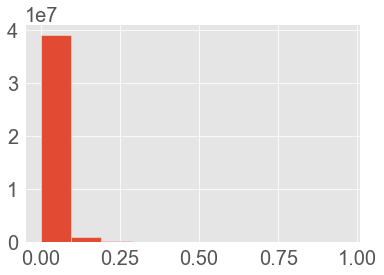

In [76]:
plt.hist(X_r.flatten())

In [83]:
df = pd.DataFrame()
df['epimutations_sum'] = sub_epimutations_sum
df.to_csv(config.ifname('epimutations'))

In [82]:
sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)

In [57]:
def distr_less(x, y, alpha = 0.05, alternative = 'two-sided'):
    ks, p = stats.ks_2samp(x, y, alternative = alternative)
    return ks, p
for alternative in ['two-sided', 'less', 'greater']:
    print(distr_less(sd[0], sd[1], alternative = alternative))
    print(distr_less(sd[0], sd[2], alternative = alternative))
    print(distr_less(sd[1], sd[2], alternative = alternative))
    print('')
'''
print(distr_less(np.log10(sd[0]), np.log10(sd[2])))
print(distr_less(np.log10(sd[0]), np.log10(sd[1])))
print(distr_less(np.log10(sd[1]), np.log10(sd[2])))
'''

(0.03948604074863926, 5.1193269502480527e-216)
(0.03217113549063888, 1.543225409745477e-143)
(0.03217113549063888, 1.543225409745477e-143)
(0.048399609285438294, 0.0)

(0.03948604074863926, 2.4605619383268044e-216)
(0.01774861726619159, 2.7143684282782443e-44)
(0.01774861726619159, 2.7143684282782443e-44)
(0.009937466825381373, 2.190453937144936e-14)

(0.002763897220712897, 0.08759832068833201)
(0.03217113549063888, 7.471841028250168e-144)
(0.03217113549063888, 7.471841028250168e-144)
(0.048399609285438294, 0.0)



'\nprint(distr_less(np.log10(sd[0]), np.log10(sd[2])))\nprint(distr_less(np.log10(sd[0]), np.log10(sd[1])))\nprint(distr_less(np.log10(sd[1]), np.log10(sd[2])))\n'

In [43]:
print(distr_less(sd[0], sd[0]))


ks =  0.0042463511845498144 pv =  0.006422628048431702
0.006422628048431702


In [21]:
n1 = 200 
n2 = 300
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

Ks_2sampResult(statistic=0.21833333333333332, pvalue=1.807865352443372e-05)